In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from scipy.signal import medfilt

data = pickle.load(open('QM3hystscan_2022_01_18.pkl','rb'))

In [2]:
data.keys()
current = data['L1:RG2:QM3:CurrentAO']
beam_charge = data['L1:CM2:measCurrentCM']
beam_charge_smooth = medfilt(beam_charge[1],21)
#beam_charge_smooth = beam_charge[1]
print(len(beam_charge_smooth))

11211


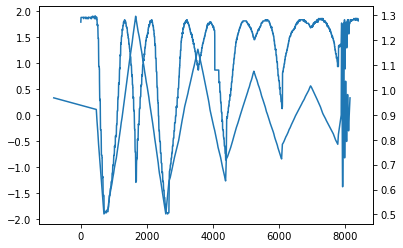

In [3]:
fig,ax = plt.subplots()
ax.plot(*current)
ax2 = ax.twinx()
ax2.plot(beam_charge[0], beam_charge_smooth)

(698, 2)
[ 47 174 310 435 534 641]


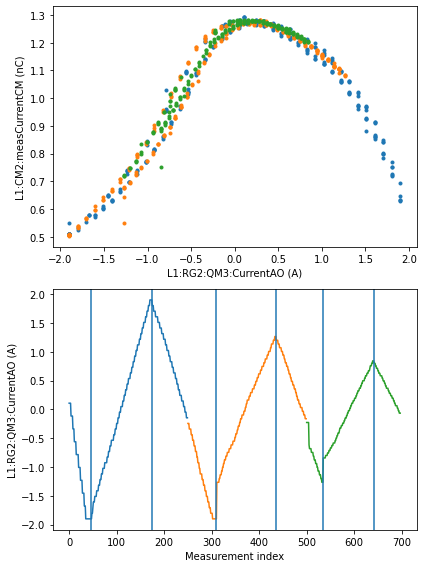

In [4]:
def identify_turning_points(input_data):
    """ find indicies where the difference goes through zero"""
    diff = input_data[1:] - input_data[:-1]
    sign = np.sign(diff)
    sz = sign == 0
    while sz.any():
        sign[sz] = np.roll(sign, 1)[sz]
        sz = sign == 0
    sign_change = ((np.roll(sign,1) - sign) != 0).astype('int')
    return np.nonzero(sign_change)[0]

# bin measured current based on timestamps for current read back
end_idx = -200
timestamps = current[0][1:end_idx]
currents = current[1][1:end_idx]
beam_charge_binned = []
for i in range(len(timestamps)-1):
    beam_charge_binned += [beam_charge_smooth[np.argwhere(
        (beam_charge[0] > timestamps[i]) & (beam_charge[0] < timestamps[i+1])
    )]]

skip = 10
beam_charge_full = []
for i in range(len(currents)-1):
    for ele in beam_charge_binned[i]:
        beam_charge_full += [[currents[i], ele]]
beam_charge_full = np.asfarray(beam_charge_full)[::skip]
print(beam_charge_full.shape)

# indices to sep cycles
cycle_indicies = np.array([0, 250, 500, len(beam_charge_full)]) * 10/skip
cycle_indicies = cycle_indicies.astype('int')

turning_points = identify_turning_points(beam_charge_full[:,0])
print(turning_points)


fig, (ax, ax2) = plt.subplots(2,1)
fig.set_size_inches(6,8)
step = np.arange(len(beam_charge_full))

ax.set_xlabel('L1:RG2:QM3:CurrentAO (A)')
ax.set_ylabel('L1:CM2:measCurrentCM (nC)')

ax2.set_xlabel('Measurement index')
ax2.set_ylabel('L1:RG2:QM3:CurrentAO (A)')
for i in range(len(cycle_indicies) - 1):
    ax.plot(*beam_charge_full[cycle_indicies[i]:cycle_indicies[i+1]].T,
            '.', c=f'C{i}')

    ax2.plot(step[cycle_indicies[i]:cycle_indicies[i+1]],
        beam_charge_full[cycle_indicies[i]:cycle_indicies[i+1]].T[0],c=f'C{i}')
for ele in turning_points:
    ax2.axvline(ele)
fig.tight_layout()
fig.savefig('experiment_data.png', dpi=300)

(229,)


C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret 

<ErrorbarContainer object of 3 artists>

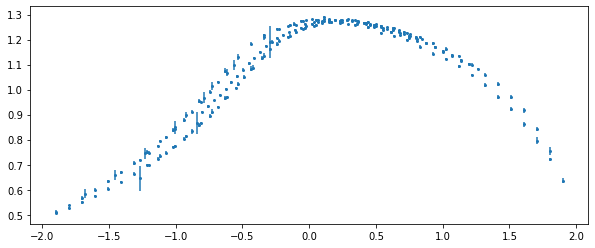

In [5]:
beam_charge_mean = np.array([np.mean(ele) for ele in beam_charge_binned])
beam_charge_std = np.array([np.std(ele) for ele in beam_charge_binned])
print(currents.shape)

fig,ax = plt.subplots()
fig.set_size_inches(10,4)
ax.errorbar(currents[:-1], beam_charge_mean, beam_charge_std,fmt='o', ms=2)

In [6]:
from gpytorch import ExactMarginalLogLikelihood
from hysteresis.hybrid import ExactHybridGP
from hysteresis.base import BaseHysteresis
import torch

# clean up data that has nans - (measurements not taken during timestep)
#train_y = beam_charge_mean[np.argwhere(~np.isnan(beam_charge_mean))]
#train_x = currents[:-1][np.argwhere(~np.isnan(beam_charge_mean))]

train_x = beam_charge_full[:,0]
train_y = beam_charge_full[:,1]

# set up training data for joint hysteresis model
train_x = torch.tensor(train_x).double().reshape(-1,1)
train_y = torch.tensor(train_y).double()



H = BaseHysteresis(
    train_x.flatten(),
    polynomial_degree=1,
    temp=1e-4,
    mesh_scale=0.5,
    trainable=True
)
print(len(H.mesh_points))
model = ExactHybridGP(train_x, train_y.flatten().clone(), H)
mll = ExactMarginalLogLikelihood(model.gp.likelihood, model)

358


In [7]:
from botorch.models import SingleTaskGP

#create normal GP model
gp = SingleTaskGP(
    train_x,
    train_y.reshape(-1,1)
)
gp_mll = ExactMarginalLogLikelihood(gp.likelihood, gp)


In [34]:
from botorch import fit_gpytorch_model
from botorch.optim.fit import fit_gpytorch_torch

res = fit_gpytorch_model(mll)
gp_res = fit_gpytorch_model(gp_mll)

for name, val in H.named_parameters():
    print(f'{name}:{val}')

raw_hysterion_density:Parameter containing:
tensor([-3.1976e-03,  1.6557e-01, -1.7241e-01, -6.2736e-03,  3.3408e-02,
         4.5723e-02, -2.3522e-02,  2.6152e-02, -4.9097e-02, -1.7548e-01,
        -2.6578e-01, -4.7193e-01,  3.8052e-01,  3.6211e-02,  4.5157e-02,
         5.2522e-02, -2.5170e-01, -2.7291e-01,  8.4894e-01, -8.5282e-01,
        -6.9953e-01, -3.6224e-01,  3.4534e-01, -2.4074e-01, -7.9533e-02,
         3.8316e-01, -1.2360e-01, -7.7653e-02, -1.3159e-02, -1.5052e-01,
        -1.3164e-02,  4.2946e-02,  6.9444e-02, -2.7606e-02, -3.8448e-02,
        -3.1093e-02, -6.2724e-04,  7.4343e-02,  9.4703e-02,  6.2412e-02,
         9.7429e-02,  9.5121e-02,  1.4334e-01,  1.4668e-01,  1.1224e-01,
         1.1893e-01,  1.3324e-01,  1.2780e-01,  1.4125e-01,  1.3588e-01,
         1.1644e-01,  1.1472e-01,  4.8347e-02,  4.8347e-02, -2.5702e-01,
        -2.0026e-01, -2.0026e-01,  6.8487e-02,  3.3127e-01,  1.6557e-01,
         2.5532e-01,  3.4359e-01,  4.3211e-01,  4.2068e-01,  3.1682e-01,
       

Visualize hysteresis effects

tensor([0.], grad_fn=<AddBackward0>)
tensor([6.8207], grad_fn=<AddBackward0>)
tensor([1.0909], grad_fn=<AddBackward0>)


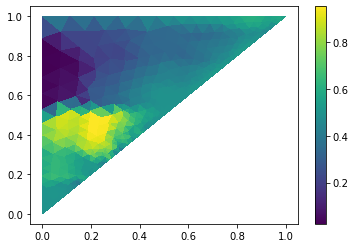

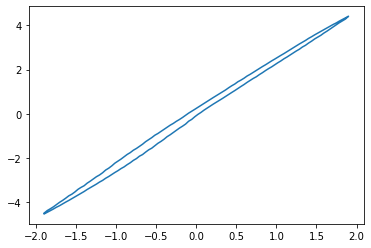

In [9]:
from copy import deepcopy
from hysteresis.visualization import plot_hysterion_density

plot_hysterion_density(model.hysteresis_models[0])

h_model = deepcopy(model.hysteresis_models[0])
h_model.regression()

print(h_model.offset)
print(h_model.slope)
print(h_model.scale)

fig,ax = plt.subplots()
test_x = torch.linspace(*h_model.valid_domain,100)
test_x = torch.cat([test_x, test_x.flipud()])

with torch.no_grad():
    out = h_model(test_x, return_real=True)

h_model.offset = h_model.offset - torch.mean(out)

with torch.no_grad():
    out = h_model(test_x, return_real=True)
ax.plot(test_x, out, '-')

torch.save(h_model,'experiment_model.pt')

Generate plot for PRL

[0, 47, 174, 250]
[0, 60, 185, 250]
[0, 34, 141, 198]
[0, 47, 174, 250]
[0, 60, 185, 250]
[0, 34, 141, 198]
[<matplotlib.lines.Line2D object at 0x0000027C2FAC7880>, <matplotlib.lines.Line2D object at 0x0000027C2FAC7EB0>, <matplotlib.lines.Line2D object at 0x0000027C2FADB280>, <matplotlib.lines.Line2D object at 0x0000027C2F8B3A60>, <matplotlib.lines.Line2D object at 0x0000027C2F8BC7C0>, <matplotlib.lines.Line2D object at 0x0000027C25092550>, <matplotlib.collections.PolyCollection object at 0x0000027C2F9D1520>, <matplotlib.collections.PolyCollection object at 0x0000027C2F8BC100>, <matplotlib.collections.PolyCollection object at 0x0000027C2F8BC430>, <matplotlib.collections.PolyCollection object at 0x0000027C2F8B3DF0>, <matplotlib.collections.PolyCollection object at 0x0000027C2F8BCE50>, <matplotlib.collections.PolyCollection object at 0x0000027C250921C0>, <matplotlib.collections.PolyCollection object at 0x0000027C2F8BCB20>, <matplotlib.collections.PolyCollection object at 0x0000027C25092B

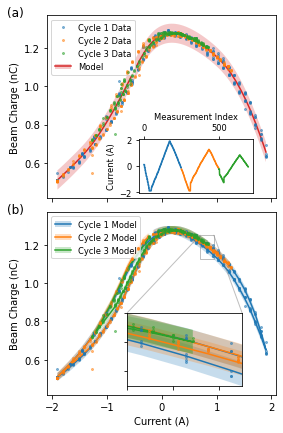

In [33]:
# compare fit to data
with torch.no_grad():
    post = model(train_x.double(), return_real=True, return_likelihood=True)
    mean_out = post.mean.flatten()
    std = torch.sqrt(post.variance).flatten()
    l = (mean_out - 2*std).flatten()
    u = (mean_out + 2*std).flatten()

fig, (axa, axb) = plt.subplots(2,1,sharex='all', sharey='all')
fig.set_size_inches(4,6)
ms=2


axins = axb.inset_axes([0.35,0.05,0.5, 0.4])
#axins.set_xlim(0.45,0.6)
#axins.set_ylim(1.225, 1.275)

axins.set_xlim(0.7,0.95)
axins.set_ylim(1.125, 1.25)

axins.set_yticklabels([])
axins.set_xticklabels([])

# plot training data
for a in [axb, axins, axa]:
    for i in range(len(cycle_indicies) - 1):
        a.plot(train_x[cycle_indicies[i]:cycle_indicies[i+1]],
               train_y[cycle_indicies[i]:cycle_indicies[i+1]],
               'o',ms=ms,c=f'C{i}',label=f'Cycle {i+1} Data',zorder=10+i,alpha=0.5)


# plot joint-model predictions
for a in [axb, axins]:
    for i in range(len(cycle_indicies) - 1):
        plot_x = train_x[cycle_indicies[i]:cycle_indicies[i+1]].flatten()
        plot_mean = mean_out[cycle_indicies[i]:cycle_indicies[i+1]].detach()
        plot_l = l[cycle_indicies[i]:cycle_indicies[i+1]]
        plot_u = u[cycle_indicies[i]:cycle_indicies[i+1]]

        # plot mean
        a.plot(plot_x, plot_mean,f'C{i}',label=f'Cycle {i+1} Model')

        # plot confidence regions (separate for each direction)
        turning_points = identify_turning_points(plot_x.numpy())
        turning_points = [0, *turning_points, len(plot_x)]
        print(turning_points)

        for j in range(len(turning_points)-1):
            a.fill_between(
                plot_x[turning_points[j] : turning_points[j+1]],
                plot_l[turning_points[j] : turning_points[j+1]],
                plot_u[turning_points[j] : turning_points[j+1]],
                alpha=0.25,fc=f'C{i}',label='s')

axb.indicate_inset_zoom(axins)

# legend for axis b
handles, labels = axb.get_legend_handles_labels()
print(handles)
new_handles = [(handles[3], handles[6]),
               (handles[4], handles[9]),
               (handles[5], handles[12])]
new_labels = labels[3:6]
axb.legend(new_handles, new_labels,loc=2, fontsize='small')



test_x = torch.linspace(*model.hysteresis_models[0].valid_domain,100).double()
with torch.no_grad():
    gp_post = gp.likelihood(gp(test_x))
    gp_mean = gp_post.mean
    gp_l, gp_u = gp_post.confidence_region()

# plot normal model predictions
axa.plot(test_x, gp_mean,'C3', label='Model')
axa.fill_between(test_x, gp_l, gp_u, alpha=0.25,fc='C3',label='Confidence')

handles, labels = axa.get_legend_handles_labels()
new_handles = [*handles[:-2],(handles[-2], handles[-1])]
new_labels = labels[:-1]
axa.legend(new_handles, new_labels,loc=2, fontsize='small')


axb.set_ylabel('Beam Charge (nC)')
axa.set_ylabel('Beam Charge (nC)')
axb.set_xlabel('Current (A)')
fig.tight_layout()

axins2 = axa.inset_axes([0.4,0.025,0.5, 0.3])
axins2.set_ylabel('Current (A)',fontsize='small')
axins2.set_xlabel('Measurement Index',fontsize='small')
axins2.xaxis.tick_top()
for ele in axins2.get_xticklabels() + axins2.get_yticklabels():
    ele.set_fontsize('small')

axins2.xaxis.set_label_position('top')

step = np.arange(len(beam_charge_full))

for i in range(len(cycle_indicies) - 1):
    axins2.plot(step[cycle_indicies[i]:cycle_indicies[i+1]],
        beam_charge_full[cycle_indicies[i]:cycle_indicies[i+1]].T[0],c=f'C{i}')

for ax, l in zip([axa,axb],['a','b']):
    ax.text(-0.1, 1.05, f'({l})', ha='right',
               va='top', transform=ax.transAxes,
               fontdict={'size': 12})

fig.savefig('experimental_modeling_paper.png', dpi=300)

Generate plot for presentations

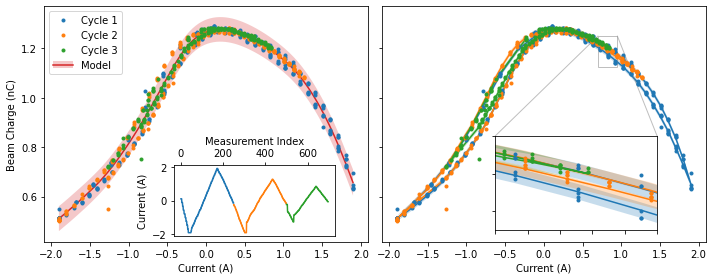

In [11]:

# compare fit to data
with torch.no_grad():
    post = model(train_x.double(), return_real=True, return_likelihood=True)
    mean_out = post.mean.flatten()
    std = torch.sqrt(post.variance).flatten()
    l = (mean_out - std).flatten()
    u = (mean_out + std).flatten()

fig, (ax2, ax) = plt.subplots(1,2,sharex='all', sharey='all')
fig.set_size_inches(10,4)
ms=3


axins = ax.inset_axes([0.35,0.05,0.5, 0.4])
#axins.set_xlim(0.45,0.6)
#axins.set_ylim(1.225, 1.275)

axins.set_xlim(0.7,0.95)
axins.set_ylim(1.125, 1.25)

axins.set_yticklabels([])
axins.set_xticklabels([])

# plot training data
for a in [ax, axins, ax2]:
    for i in range(len(cycle_indicies) - 1):
        a.plot(train_x[cycle_indicies[i]:cycle_indicies[i+1]],
               train_y[cycle_indicies[i]:cycle_indicies[i+1]],
               'o',ms=ms,c=f'C{i}',label=f'Cycle {i+1}',zorder=5+i)



for a in [ax, axins]:
    for i in range(len(cycle_indicies) - 1):
        a.plot(train_x[cycle_indicies[i]:cycle_indicies[i+1]],
               mean_out[cycle_indicies[i]:cycle_indicies[i+1]].detach(),
               f'C{i}')
        a.fill_between(train_x.flatten()[cycle_indicies[i]:cycle_indicies[i+1]],
                       l[cycle_indicies[i]:cycle_indicies[i+1]],
                       u[cycle_indicies[i]:cycle_indicies[i+1]],
                       alpha=0.25,fc=f'C{i}')
ax.indicate_inset_zoom(axins)

test_x = torch.linspace(*model.hysteresis_models[0].valid_domain,100).double()
with torch.no_grad():
    gp_post = gp.likelihood(gp(test_x))
    gp_mean = gp_post.mean
    gp_l, gp_u = gp_post.confidence_region()

ax2.plot(test_x, gp_mean,'C3', label='Model')
ax2.fill_between(test_x, gp_l, gp_u, alpha=0.25,fc='C3',label='Confidence')

handles, labels = ax2.get_legend_handles_labels()
new_handles = [*handles[:-2],(handles[-2], handles[-1])]
new_labels = labels[:-1]
ax2.legend(new_handles, new_labels)

ax.set_xlabel('Current (A)')
ax2.set_ylabel('Beam Charge (nC)')
ax2.set_xlabel('Current (A)')
fig.tight_layout()

axins2 = ax2.inset_axes([0.4,0.025,0.5, 0.3])
axins2.set_ylabel('Current (A)')
axins2.set_xlabel('Measurement Index')
axins2.xaxis.tick_top()
axins2.xaxis.set_label_position('top')

step = np.arange(len(beam_charge_full))

for i in range(len(cycle_indicies) - 1):
    axins2.plot(step[cycle_indicies[i]:cycle_indicies[i+1]],
        beam_charge_full[cycle_indicies[i]:cycle_indicies[i+1]].T[0],c=f'C{i}')



#fig.savefig('experimental_modeling_presentation.png', dpi=300)
